In [17]:
from sparse_discrete_table import SparseDiscreteTable, build_discrete_table
from ipywidgets import widgets
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
from utils.data_processing import time_series_to_time_index
from pprint import pprint

from sparse_discrete_table import quick_mutual_info, quick_cond_mutual_info
from sparse_discrete_table import mutual_info_over_time, conditional_mutual_info_over_time
from utils.interactive import filter_frame, get_total_counts, new_bins, new_int_bins
from utils.interactive import get_mean_map, bin_data_frame, State

In [18]:
pd.set_option('mode.chained_assignment', None)

In [19]:
df = pd.read_pickle("data/raw/Crimes_Chicago_2001_to_2019_datetime_fmt.pkl")

In [20]:
df = pd.read_pickle("data/raw/Crimes_Chicago_2001_to_2019_datetime_fmt.pkl")

In [21]:
# used to remove the anomalies
LAT_MIN, LAT_MAX = 41.6445, 42.0228

LON_MIN, LON_MAX = -87.9344, -87.5244


FREQ = '1D' # '1H' #

if FREQ == '1D':
    DATE_MIN, DATE_MAX = '2012-02-01', '2018-01-01'
else:
    DATE_MIN, DATE_MAX = '2012-02-01', '2012-10-01'

crime_categories = [
        "THEFT",
        "BATTERY",
        "CRIMINAL DAMAGE",
        "NARCOTICS",
        "ASSAULT",
        "BURGLARY",
        "MOTOR VEHICLE THEFT",
        "ROBBERY",
]

lon_mask = (df.Longitude > LON_MIN) & (df.Longitude < LON_MAX)
lat_mask = (df.Latitude > LAT_MIN) & (df.Latitude < LAT_MAX)
date_mask = (df.Date >= DATE_MIN) & (df.Date < DATE_MAX)
category_mask = df['Primary Type'].isin(crime_categories)

In [22]:
df = df[lon_mask & lat_mask & date_mask & category_mask]

In [23]:
from pandas.api.types import CategoricalDtype
# Label encode the crime catgegories - makes histograms faster
CrimeType = CategoricalDtype(categories=crime_categories, ordered=True)
df['Primary Type'] = df['Primary Type'].astype(CrimeType)
df['c'] = df['Primary Type'].cat.codes

In [24]:
df['t'] = time_series_to_time_index(t_series=df.Date, t_step=FREQ, floor=True)
# df['t'] = time_series_to_time_index(t_series=df.Date, t_step='1H', floor=True)

In [25]:
# date selectors
date_range = pd.date_range(df.Date.min().ceil(FREQ), df.Date.max().floor(FREQ), freq=FREQ)

In [26]:
from geopy import distance
from utils.utils import ffloor, fceil

# get meter per degree estimat
coord_series = df[['Latitude', 'Longitude']]

lat_min, lon_min = coord_series.min()
lat_max, lon_max = coord_series.max()

lat_mean, lon_mean = coord_series.mean()

dy = distance.distance((lat_min, lon_min), (lat_max, lon_min)).m
dx = distance.distance((lat_min, lon_min), (lat_min, lon_max)).m

lat_per_metre = (lat_max - lat_min)/dy
lon_per_metre = (lon_max - lon_min)/dx

ratio_xy = dx/dy
print(f"ratio_xy: {ratio_xy}")
print(f"lat_per_metre: {lat_per_metre}")
print(f"lon_per_metre: {lon_per_metre}")

ratio_xy: 0.8127895963778615
lat_per_metre: 9.003326781922841e-06
lon_per_metre: 1.2003344797182708e-05


In [27]:
# [20,16] - [10,8] - [5,4] - [3,2] - [1,1]
x_scale, y_scale = 10,8 #3,2
xy_scale = np.array([x_scale, y_scale])  # must be integer so that we can easily sample demographic data
dlon, dlat = xy_scale * np.array([0.001, 0.001])
meta_info = {}
meta_info["x_scale"] = x_scale
meta_info["y_scale"] = y_scale
meta_info["dlon"] = float(dlon)
meta_info["dlat"] = float(dlat)
meta_info["x in metres"] = 85000 * float(dlon)
meta_info["y in metres"] = 110000 * float(dlat)

pprint(meta_info)

# use perfect squares perfect squares
"""
all the meta data is mapped from intervals of 0.001 in 
the lat and lon space with ratios of 8 and 11 to ensure that the grids cels are square
"""
# cell_size_m = 430
# dlat = cell_size_m*lat_per_metre
# dlon = cell_size_m*lon_per_metre
 
# use increments of 0.001

{'dlat': 0.008,
 'dlon': 0.01,
 'x in metres': 850.0,
 'x_scale': 10,
 'y in metres': 880.0,
 'y_scale': 8}


'\nall the meta data is mapped from intervals of 0.001 in \nthe lat and lon space with ratios of 8 and 11 to ensure that the grids cels are square\n'

In [28]:
from pprint import pformat        
        
def default_state():
    return  State(
        dlon=dlon,
        dlat=dlat,
        lon_max = LON_MAX,
        lon_min = LON_MIN,
        lat_max = LAT_MAX,
        lat_min = LAT_MIN,     
        total_lon_max = LON_MAX,
        total_lon_min = LON_MIN,
        total_lat_max = LAT_MAX,
        total_lat_min = LAT_MIN,         
        date_min = DATE_MIN,
        date_max = DATE_MAX,                
        time_index = 0,
        date_indices = (0,len(date_range)-1),
        date_range = pd.date_range(df.Date.min().ceil(FREQ), df.Date.max().floor(FREQ), freq=FREQ),
        freq=FREQ,
        crime_types = [*crime_categories],    
        mi_max_offset = 35,
        block_size_index=1,    
        conditional_temporal_variables= ["Day of Week"],# ["Hour", "Day of Week", "Time of Month", "Time of Year"],
    )
    
state = default_state()
state

{'block_size_index': 1,
 'callbacks': [],
 'conditional_temporal_variables': ['Day of Week'],
 'crime_types': ['THEFT',
                 'BATTERY',
                 'CRIMINAL DAMAGE',
                 'NARCOTICS',
                 'ASSAULT',
                 'BURGLARY',
                 'MOTOR VEHICLE THEFT',
                 'ROBBERY'],
 'date_indices': (0, 2160),
 'date_max': '2018-01-01',
 'date_min': '2012-02-01',
 'date_range': DatetimeIndex(['2012-02-01', '2012-02-02', '2012-02-03', '2012-02-04',
               '2012-02-05', '2012-02-06', '2012-02-07', '2012-02-08',
               '2012-02-09', '2012-02-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', length=2161, freq='D'),
 'dlat': 0.008,
 'dlon': 0.01,
 'freq': '1D',
 'lat_max': 42.0228,
 'lat_min': 41.6445,
 'lon_max': -87.5244,
 

In [29]:
tbins, cbins, ybins, xbins = new_bins(df, state)

In [30]:
import matplotlib.pyplot as plt

In [31]:
year_divisions = 24
month_divisions = 4

df["Hour"] = df.Date.dt.hour
df["DayOfWeek"] = df.Date.dt.dayofweek
df["TimeOfMonth"] = np.floor((month_divisions-1e-8)*df.Date.dt.day/df.Date.dt.days_in_month)
df["TimeOfYear"] = np.floor((year_divisions-1e-8)*df.Date.dt.dayofyear/(365 + df.Date.dt.is_leap_year*1))

h_bins = new_int_bins(df["Hour"].min(),df["Hour"].max())
dow_bins = new_int_bins(df["DayOfWeek"].min(),df["DayOfWeek"].max())
tom_bins = new_int_bins(df["TimeOfMonth"].min(),df["TimeOfMonth"].max())
toy_bins = new_int_bins(df["TimeOfYear"].min(),df["TimeOfYear"].max())

# Sklearn analysis on crime type classification and similarities

In [32]:
from sklearn.preprocessing import normalize # normalize should only be used on individual vectors/ mastrices
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [33]:
sub = df.sample(150_000)

In [34]:
sub = sub[sub['Primary Type'].isin(['THEFT', 'NARCOTICS'])]
sub

,ID,Date,Primary Type,Arrest,Latitude,Longitude,c,t,Hour,DayOfWeek,TimeOfMonth,TimeOfYear
1476991,9503515,2014-01-20 14:00:00,THEFT,False,41.897267,-87.632721,0,719,14,0,2.0,1.0
596539,10931402,2017-05-01 21:17:00,NARCOTICS,True,41.894146,-87.710176,3,1916,21,0,0.0,7.0
1706203,9111078,2013-04-23 00:00:00,THEFT,False,41.863457,-87.652551,0,447,0,1,3.0,7.0
971232,10329240,2015-11-30 17:40:00,THEFT,False,41.965250,-87.668187,0,1398,17,0,3.0,21.0
719395,10744068,2016-11-05 10:00:00,THEFT,False,41.929744,-87.684274,0,1739,10,5,0.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1277406,9805431,2014-10-03 20:10:00,NARCOTICS,True,41.779203,-87.687836,3,975,20,4,0.0,18.0
1313339,9744808,2014-08-20 06:00:00,THEFT,False,41.874363,-87.643013,0,931,6,2,2.0,15.0
688132,10789440,2016-12-21 00:30:00,THEFT,False,41.920825,-87.769523,0,1785,0,2,2.0,23.0
1010129,10277611,2015-10-06 22:30:00,THEFT,False,41.802420,-87.667240,0,1343,22,1,0.0,18.0


In [35]:
color_palette = ["#33a8c7","#52e3e1","#a0e426","#fdf148","#ffab00","#f77976","#f050ae","#d883ff","#9336fd"]
def i2c(i):
    return color_palette[i]
i2c = np.vectorize(i2c)

In [36]:
X = sub[['Latitude', 'Longitude','Hour', 'DayOfWeek', 'TimeOfMonth', 'TimeOfYear']].values # 
y = sub[['c']].values.reshape(-1) 

In [49]:
Xnorm1 = MinMaxScaler().fit_transform(X[:,:2])
Xnorm2 = MinMaxScaler().fit_transform(X[:,2:]) # OneHotEncoder().fit_transform(X[:,2:]).toarray()
Xnorm =np.concatenate((Xnorm1,Xnorm2),axis=1)

In [39]:
from sklearn.metrics import f1_score, roc_auc_score

In [50]:
clf = MLPClassifier(hidden_layer_sizes=(100,),max_iter=1000, verbose=True)
clf.fit(Xnorm,y)
y_hat = clf.predict(Xnorm)
accuracy_score(y_hat, y)

Iteration 1, loss = 0.56924513
Iteration 2, loss = 0.54933384
Iteration 3, loss = 0.54294352
Iteration 4, loss = 0.53829334
Iteration 5, loss = 0.53472338
Iteration 6, loss = 0.53104519
Iteration 7, loss = 0.52695680
Iteration 8, loss = 0.52332329
Iteration 9, loss = 0.51932492
Iteration 10, loss = 0.51552400
Iteration 11, loss = 0.51240372
Iteration 12, loss = 0.50873949
Iteration 13, loss = 0.50577411
Iteration 14, loss = 0.50308997
Iteration 15, loss = 0.50079710
Iteration 16, loss = 0.49852892
Iteration 17, loss = 0.49694239
Iteration 18, loss = 0.49520984
Iteration 19, loss = 0.49408015
Iteration 20, loss = 0.49252967
Iteration 21, loss = 0.49151959
Iteration 22, loss = 0.49054649
Iteration 23, loss = 0.48972103
Iteration 24, loss = 0.48900674
Iteration 25, loss = 0.48862642
Iteration 26, loss = 0.48768749
Iteration 27, loss = 0.48734133
Iteration 28, loss = 0.48711579
Iteration 29, loss = 0.48687559
Iteration 30, loss = 0.48632528
Iteration 31, loss = 0.48581382
Iteration 32, los

0.7829731073136452

In [52]:
y_hat = clf.predict(Xnorm)
y_proba = clf.predict_proba(Xnorm)

In [53]:
accuracy_score(y,y_hat)

0.7829731073136452

In [54]:
y_class = OneHotEncoder().fit_transform(y.reshape(-1,1)).toarray()

In [56]:
f1_score(y/3,y_hat/3)

0.46192418833928267

In [57]:
roc_auc_score(y_class,y_proba)

0.8046407374327135

In [58]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(Xnorm)

go.Figure(
    go.Scatter(
        x=X_pca[:1000,0],
        y=X_pca[:1000,1],
        mode='markers', 
        opacity=0.3,
        marker_color=y), 
    layout_height=800,
    layout_width=800,
)

In [59]:
grouped_dfs = {k:df[df['Primary Type'] == k] for k in crime_categories}

In [ ]:
from sklearn.metrics import co

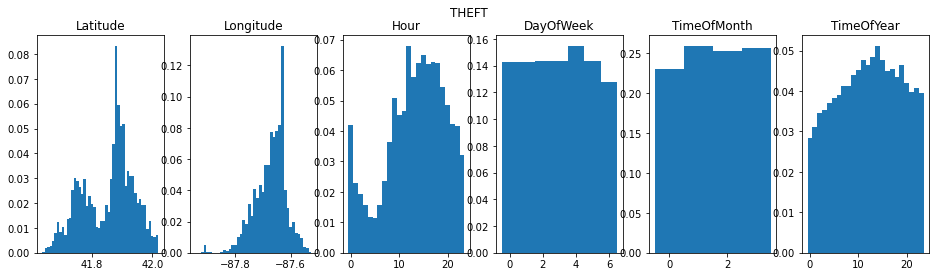

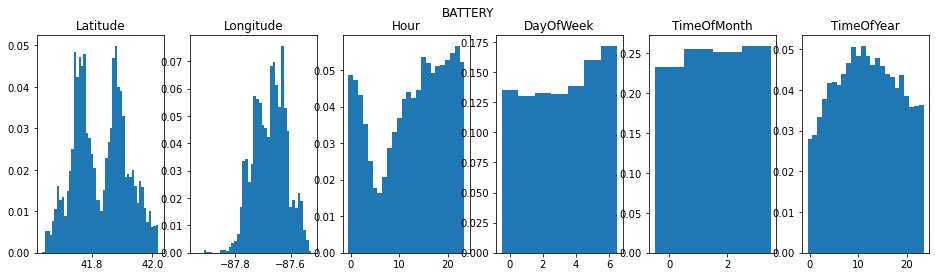

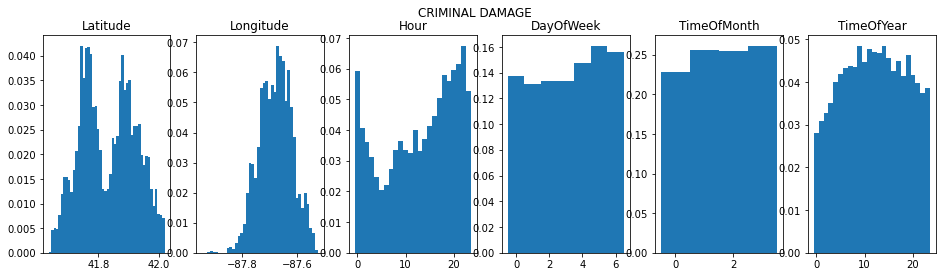

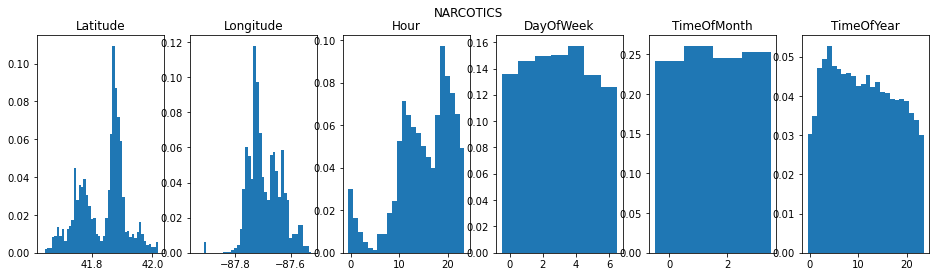

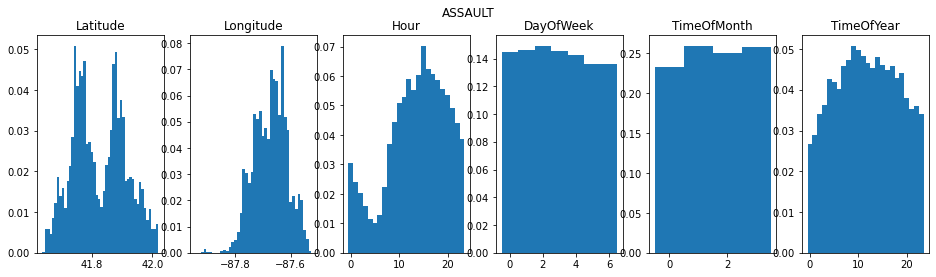

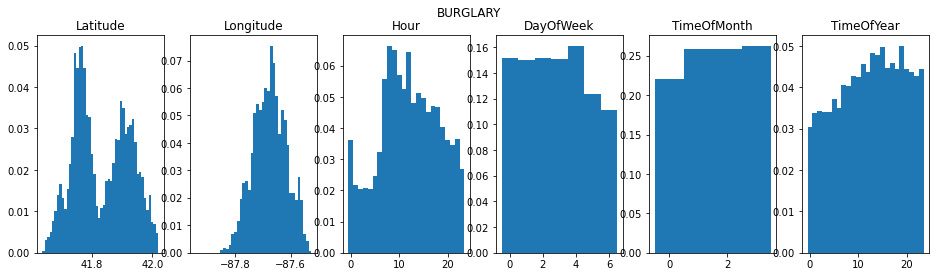

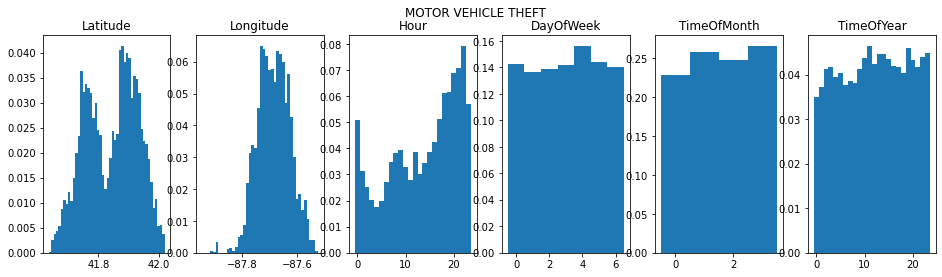

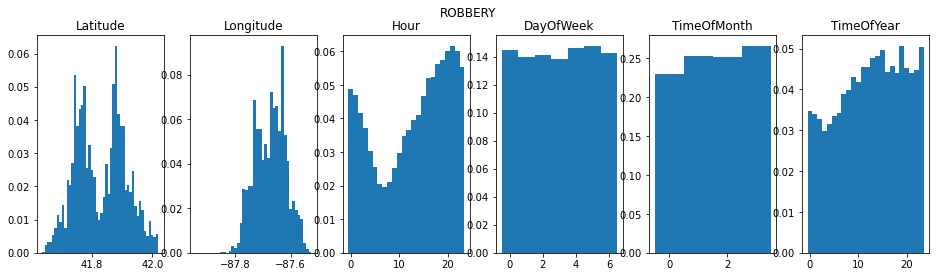

In [61]:
crime_type_dists = dict()

for k, gdf in grouped_dfs.items():
    
    crime_type_dists[k] = dict()

    ycounts, ybins = np.histogram(gdf.Latitude, ybins)
    ydist = ycounts/np.sum(ycounts)

    xcounts, xbins = np.histogram(gdf.Longitude, xbins)
    xdist = xcounts/np.sum(xcounts)

    h_counts, h_bins = np.histogram(gdf.Hour, h_bins)
    h_dist = h_counts/np.sum(h_counts)

    dow_counts, dow_bins = np.histogram(gdf.DayOfWeek, dow_bins)
    dow_dist = dow_counts/np.sum(dow_counts)

    tom_counts, tom_bins = np.histogram(gdf.TimeOfMonth, tom_bins)
    tom_dist = tom_counts/np.sum(tom_counts)

    toy_counts, toy_bins = np.histogram(gdf.TimeOfYear, toy_bins)
    toy_dist = toy_counts/np.sum(toy_counts)


    fig, ax = plt.subplots(1,6)
    fig.suptitle(k)
    fig.set_figwidth(16)
    
    ax[0].set_title("Latitude")
    ax[1].set_title("Longitude")
    ax[2].set_title("Hour")
    ax[3].set_title("DayOfWeek")
    ax[4].set_title("TimeOfMonth")
    ax[5].set_title("TimeOfYear")
    
    
    crime_type_dists[k]["Latitude"] = ydist
    crime_type_dists[k]["Longitude"] = xdist
    crime_type_dists[k]["Hour"] = h_dist
    crime_type_dists[k]["DayOfWeek"] = dow_dist
    crime_type_dists[k]["TimeOfMonth"] = tom_dist
    crime_type_dists[k]["TimeOfYear"] = toy_dist
    
    
    ax[0].bar(ybins[:-1],ydist, width=ybins[1]-ybins[0])
    ax[1].bar(xbins[:-1],xdist, width=xbins[1]-xbins[0])
    ax[2].bar(h_bins[:-1],h_dist, width=h_bins[1]-h_bins[0])
    ax[3].bar(dow_bins[:-1],dow_dist, width=dow_bins[1]-dow_bins[0])
    ax[4].bar(tom_bins[:-1],tom_dist, width=tom_bins[1]-tom_bins[0])
    ax[5].bar(toy_bins[:-1],toy_dist, width=toy_bins[1]-toy_bins[0])

    plt.show(fig)

In [64]:
from sklearn.metrics.pairwise import cosine_similarity

In [86]:
sims = dict()
for i, (itype, idists) in enumerate(crime_type_dists.items()):
    for j, (jtype, jdists) in enumerate(crime_type_dists.items()):
        if i > j:
            c = (itype,jtype)
            print(c)
            sims[c] = dict()
            for feature in ["Latitude","Longitude","Hour","DayOfWeek","TimeOfMonth","TimeOfYear"]:
                sim = cosine_similarity(idists[feature].reshape(1, -1), jdists[feature].reshape(1, -1))[0,0]
                print(f"\t{feature:15} {sim}")
                sims[c][feature] = sim

('BATTERY', 'THEFT')
	Latitude        0.922551314616673
	Longitude       0.9430000252477597
	Hour            0.9506869150964359
	DayOfWeek       0.989785398999174
	TimeOfMonth     0.9999485696651699
	TimeOfYear      0.9969566515623963
('CRIMINAL DAMAGE', 'THEFT')
	Latitude        0.9254945134563778
	Longitude       0.9307004946709557
	Hour            0.9312012079146803
	DayOfWeek       0.9948033550378931
	TimeOfMonth     0.9999028206295852
	TimeOfYear      0.998676211656911
('CRIMINAL DAMAGE', 'BATTERY')
	Latitude        0.9861784139967981
	Longitude       0.9932123066684955
	Hour            0.9880956929585666
	DayOfWeek       0.9988066023552913
	TimeOfMonth     0.9999349717589757
	TimeOfYear      0.9987916800379747
('NARCOTICS', 'THEFT')
	Latitude        0.8902566495290661
	Longitude       0.793754120659565
	Hour            0.9264796888976158
	DayOfWeek       0.9992115054595204
	TimeOfMonth     0.9996118262181201
	TimeOfYear      0.9848465676036077
('NARCOTICS', 'BATTERY')
	Latitude  